In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ir-2025-spooky-author-identification/sample_submission/sample_submission.csv
/kaggle/input/ir-2025-spooky-author-identification/test/test.csv
/kaggle/input/ir-2025-spooky-author-identification/train/train.csv


# **Importing Dataset & Train Test**

In [2]:
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train = pd.read_csv("/kaggle/input/ir-2025-spooky-author-identification/train/train.csv")
test = pd.read_csv("/kaggle/input/ir-2025-spooky-author-identification/test/test.csv")
sample = pd.read_csv("/kaggle/input/ir-2025-spooky-author-identification/sample_submission/sample_submission.csv")

# **Preprocessing**

In [4]:
train.head(5)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
test.head(5)

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
sample.head(5)

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [7]:
print("Train: rows:{} cols:{}".format(train.shape[0], train.shape[1]))
print("Test: rows:{} cols:{}".format(test.shape[0], test.shape[1]))
print("Sample: rows:{} cols:{}".format(sample.shape[0], sample.shape[1]))

Train: rows:19579 cols:3
Test: rows:8392 cols:2
Sample: rows:8392 cols:4


In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8392 entries, 0 to 8391
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8392 non-null   object 
 1   EAP     8392 non-null   float64
 2   HPL     8392 non-null   float64
 3   MWS     8392 non-null   float64
dtypes: float64(3), object(1)
memory usage: 262.4+ KB


In [9]:
sample.describe()

,EAP,HPL,MWS
count,8.392000e+03,8.392000e+03,8.392000e+03
mean,4.034935e-01,2.878084e-01,3.086981e-01
std,4.579943e-14,1.593265e-14,1.460030e-14
min,4.034935e-01,2.878084e-01,3.086981e-01
25%,4.034935e-01,2.878084e-01,3.086981e-01
50%,4.034935e-01,2.878084e-01,3.086981e-01
75%,4.034935e-01,2.878084e-01,3.086981e-01
max,4.034935e-01,2.878084e-01,3.086981e-01


In [10]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [11]:
missing_data(train)

,Total,Percent
id,0,0.0
text,0,0.0
author,0,0.0


In [12]:
missing_data(test)

,Total,Percent
id,0,0.0
text,0,0.0


In [13]:
sample.duplicated().sum()

0

Cleaning

In [14]:
import re
import spacy
import nltk
import numpy as np
from nltk.corpus import stopwords
from concurrent.futures import ThreadPoolExecutor

nltk.download('stopwords')
spacy_process = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

pattern = re.compile(r'\b([a-zA-Z])\b|\d+|[.,!?()-:;]')

stop_words = set(stopwords.words('english'))

def get_processed_text(text):
    """
    Return lemmatized text without single letters and digits.
    Everything is in the lower case register.
    """
    text = pattern.sub('', text.lower())
    lemmas = spacy_process(text)
    lemmas = [token.lemma_ for token in lemmas if token.text not in stop_words]
    return ' '.join(lemmas)

def get_clean_text(texts):
    """
    Clean an array of texts using thread-based parallelization.
    """
    with ThreadPoolExecutor() as executor:
        clean_texts = list(executor.map(get_processed_text, texts))
    return np.array(clean_texts)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
train_clean_data = get_clean_text(train['text'].values)
test_clean_data = get_clean_text(test['text'].values)

In [16]:
train_clean_data[35]

'cry aloud   little later give   gasp terrible   cry'

In [17]:
print(train['text'].values[35])

He cried aloud once, and a little later gave a gasp that was more terrible than a cry.


In [18]:
# Cleaning
del spacy_process, pattern, stop_words
del get_clean_text, get_processed_text

In [19]:
EAP_len = train[train['author'] == 'EAP'].shape[0]
HPL_len = train[train['author'] == 'HPL'].shape[0]
MWS_len = train[train['author'] == 'MWS'].shape[0]

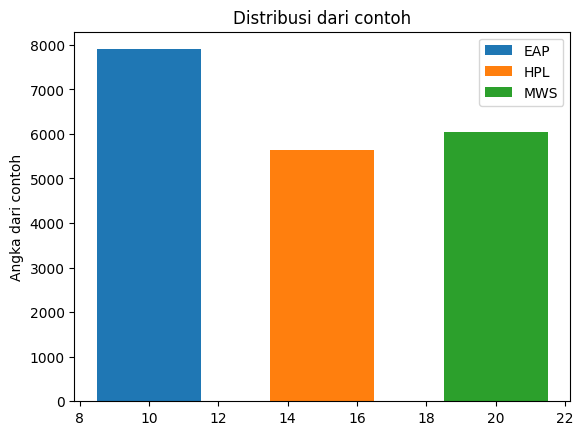

In [20]:
plt.bar(10,EAP_len,3, label="EAP")
plt.bar(15,HPL_len,3, label="HPL")
plt.bar(20,MWS_len,3, label="MWS")
plt.legend()
plt.ylabel('Angka dari contoh')
plt.title('Distribusi dari contoh')
plt.show()

In [21]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [22]:
train['text_raw'] = train['text']  # Simpan versi asli dulu
train['text_cleaned'] = train['text'].apply(remove_punctuation)

pd.set_option('display.max_colwidth', None)
train[['text_raw', 'text_cleaned']].head(10)

,text_raw,text_cleaned
0,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall
1,It never once occurred to me that the fumbling might be a mere mistake.,It never once occurred to me that the fumbling might be a mere mistake
2,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction
3,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair
4,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk
5,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew I felt myself peculiarly fortunate in being able to secure his services
6,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",The astronomer perhaps at this point took refuge in the suggestion of non luminosity and here analogy was suddenly let fall
7,The surcingle hung in ribands from my body.,The surcingle hung in ribands from my body
8,"I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not avoid casting your eyes upward to the great nebula in Orion, and I certainly expected that you would do so.",I knew that you could not say to yourself stereotomy without being brought to think of atomies and thus of the theories of Epicurus and since when we discussed this subject not very long ago I mentioned to you how singularly yet with how little notice the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony I felt that you could not avoid casting your eyes upward to the great nebula in Orion

In [23]:
train['text'] = train['text'].apply(remove_punctuation)
train.head(10)

,id,text,author,text_raw,text_cleaned
0,id26305,This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall,EAP,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall
1,id17569,It never once occurred to me that the fumbling might be a mere mistake,HPL,It never once occurred to me that the fumbling might be a mere mistake.,It never once occurred to me that the fumbling might be a mere mistake
2,id11008,In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction,EAP,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction
3,id27763,How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair,MWS,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair
4,id12958,Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk,HPL,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk
5,id22965,A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew I felt myself peculiarly fortunate in being able to secure his services,MWS,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his 

In [24]:
# import nltk dan library stopword
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords

sw = stopwords.words('english')
print(sw) 

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [26]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  198


In [27]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [28]:
train['text'] = train['text'].apply(stopwords)
train.head(10)

,id,text,author,text_raw,text_cleaned
0,id26305,process however afforded means ascertaining dimensions dungeon might make circuit return point whence set without aware fact perfectly uniform seemed wall,EAP,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall
1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling might be a mere mistake.,It never once occurred to me that the fumbling might be a mere mistake
2,id11008,left hand gold snuff box capered hill cutting manner fantastic steps took snuff incessantly air greatest possible self satisfaction,EAP,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction
3,id27763,lovely spring looked windsor terrace sixteen fertile counties spread beneath speckled happy cottages wealthier towns looked former years heart cheering fair,MWS,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair
4,id12958,finding nothing else even gold superintendent abandoned attempts perplexed look occasionally steals countenance sits thinking desk,HPL,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk
5,id22965,youth passed solitude best years spent gentle feminine fosterage refined groundwork character cannot overcome intense distaste usual brutality exercised board ship never believed necessary heard mariner equally noted kindliness heart respect obedience paid crew felt peculiarly fortunate able secure services,MWS,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew I felt myself peculiarly fortunate in being able to secure his services
6,id09674,astronomer perhaps point took refuge suggestion non luminosity analogy suddenly let fall,EAP,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",The astronomer perhaps

In [29]:
from nltk.tokenize import RegexpTokenizer

qword_tokenizer = RegexpTokenizer(r'\w+')

sample = train['text'].iloc[0] 

words = qword_tokenizer.tokenize(sample)
print(words)

['process', 'however', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', 'might', 'make', 'circuit', 'return', 'point', 'whence', 'set', 'without', 'aware', 'fact', 'perfectly', 'uniform', 'seemed', 'wall']


In [30]:
# import vectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(train['text'])
dictionary = count_vectorizer.vocabulary_.items()  

In [32]:
vocab = []
count = []
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
vocab_bef_stem = pd.Series(count, index=vocab)
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

<Axes: >

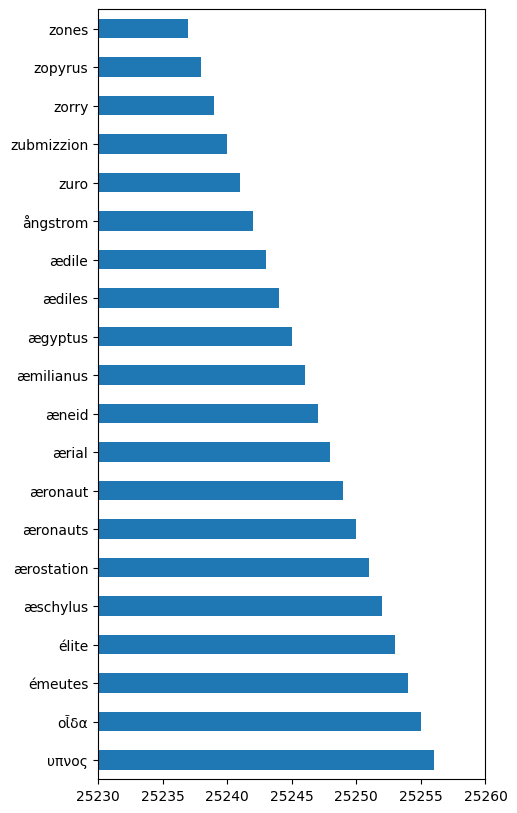

In [33]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (25230, 25260))

In [34]:
# import Stemming
from nltk.stem.snowball import SnowballStemmer

In [35]:
stemmer = SnowballStemmer("english")

def stemming(text):
    '''a function which stems each word in the given text'''
    text = str(text)
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

In [36]:
train['text'] = train['text'].apply(stemming)
train.head(10)

,id,text,author,text_raw,text_cleaned
0,id26305,process howev afford mean ascertain dimens dungeon might make circuit return point whenc set without awar fact perfect uniform seem wall,EAP,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall
1,id17569,never occur fumbl might mere mistak,HPL,It never once occurred to me that the fumbling might be a mere mistake.,It never once occurred to me that the fumbling might be a mere mistake
2,id11008,left hand gold snuff box caper hill cut manner fantast step took snuff incess air greatest possibl self satisfact,EAP,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction
3,id27763,love spring look windsor terrac sixteen fertil counti spread beneath speckl happi cottag wealthier town look former year heart cheer fair,MWS,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair
4,id12958,find noth els even gold superintend abandon attempt perplex look occasion steal counten sit think desk,HPL,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk
5,id22965,youth pass solitud best year spent gentl feminin fosterag refin groundwork charact cannot overcom intens distast usual brutal exercis board ship never believ necessari heard marin equal note kindli heart respect obedi paid crew felt peculiar fortun abl secur servic,MWS,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew I felt myself peculiarly fortunate in being able to secure his services
6,id09674,astronom perhap point took refug suggest non luminos analog sudden let fall,EAP,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",The astronomer perhaps at this point took refuge in the suggestion of non luminosity and here analogy was suddenly let fall
7,id13515,surcingl hung riband bodi,EAP,The 

In [37]:
#import tfid vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_vectorizer = TfidfVectorizer(stop_words="english")
tfid_vectorizer.fit(train['text'])
vocab = tfid_vectorizer.vocabulary_

<Axes: >

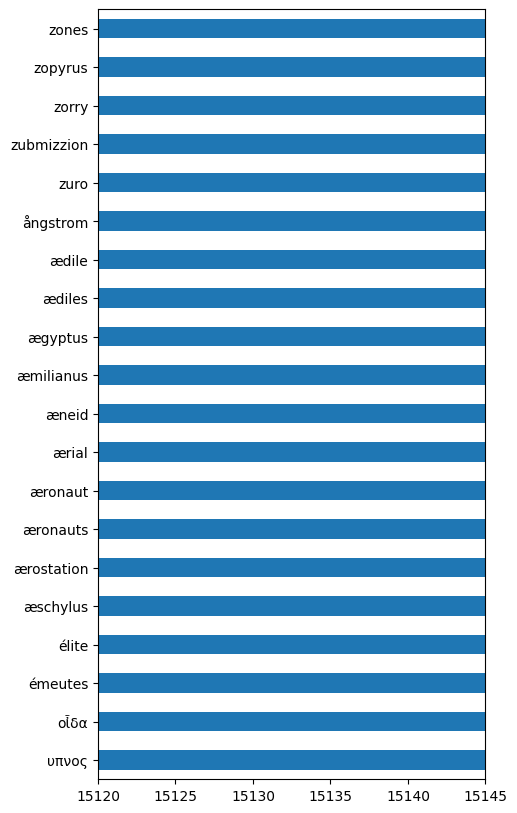

In [39]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (15120, 15145))

In [40]:
def length(train):    
    '''a function which returns the length of text'''
    return len(train)

In [41]:
train['length'] = train['text'].apply(length)
train.head(10)

,id,text,author,text_raw,text_cleaned,length
0,id26305,process howev afford mean ascertain dimens dungeon might make circuit return point whenc set without awar fact perfect uniform seem wall,EAP,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.",This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfectly uniform seemed the wall,136
1,id17569,never occur fumbl might mere mistak,HPL,It never once occurred to me that the fumbling might be a mere mistake.,It never once occurred to me that the fumbling might be a mere mistake,35
2,id11008,left hand gold snuff box caper hill cut manner fantast step took snuff incess air greatest possibl self satisfact,EAP,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.",In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction,113
3,id27763,love spring look windsor terrac sixteen fertil counti spread beneath speckl happi cottag wealthier town look former year heart cheer fair,MWS,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.",How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath speckled by happy cottages and wealthier towns all looked as in former years heart cheering and fair,137
4,id12958,find noth els even gold superintend abandon attempt perplex look occasion steal counten sit think desk,HPL,"Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.",Finding nothing else not even gold the Superintendent abandoned his attempts but a perplexed look occasionally steals over his countenance as he sits thinking at his desk,102
5,id22965,youth pass solitud best year spent gentl feminin fosterag refin groundwork charact cannot overcom intens distast usual brutal exercis board ship never believ necessari heard marin equal note kindli heart respect obedi paid crew felt peculiar fortun abl secur servic,MWS,"A youth passed in solitude, my best years spent under your gentle and feminine fosterage, has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship: I have never believed it to be necessary, and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew, I felt myself peculiarly fortunate in being able to secure his services.",A youth passed in solitude my best years spent under your gentle and feminine fosterage has so refined the groundwork of my character that I cannot overcome an intense distaste to the usual brutality exercised on board ship I have never believed it to be necessary and when I heard of a mariner equally noted for his kindliness of heart and the respect and obedience paid to him by his crew I felt myself peculiarly fortunate in being able to secure his services,265
6,id09674,astronom perhap point took refug suggest non luminos analog sudden let fall,EAP,"The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.",The astronomer perhaps at this point took refuge in the suggestion of non luminosity and here analogy was suddenly let fall,75
7,id13515,s

In [42]:
EAP_data = train[train['author'] == 'EAP']
HPL_data = train[train['author'] == 'HPL']
MWS_data = train[train['author'] == 'MWS']

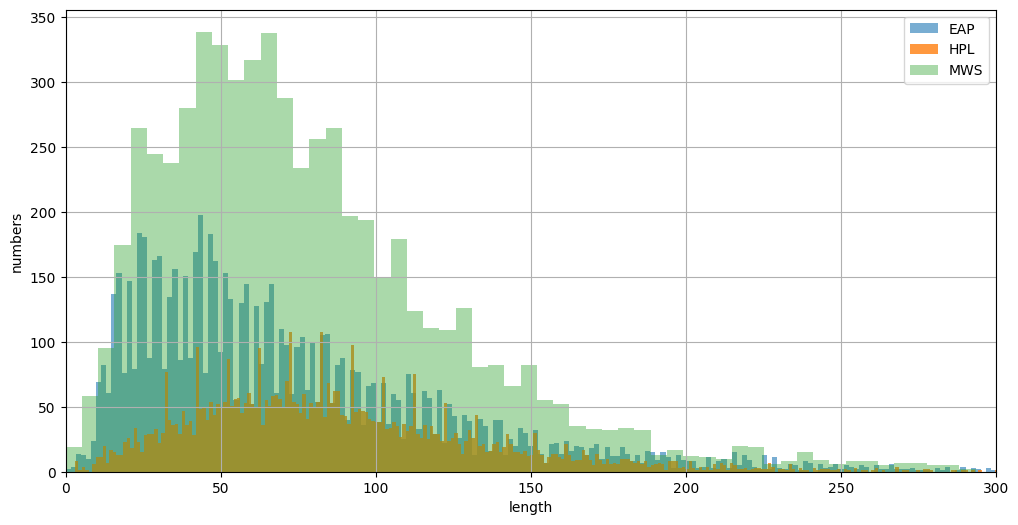

In [43]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(EAP_data['length'], alpha = 0.6, bins=bins, label='EAP')
plt.hist(HPL_data['length'], alpha = 0.8, bins=bins, label='HPL')
plt.hist(MWS_data['length'], alpha = 0.4, bins=bins, label='MWS')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

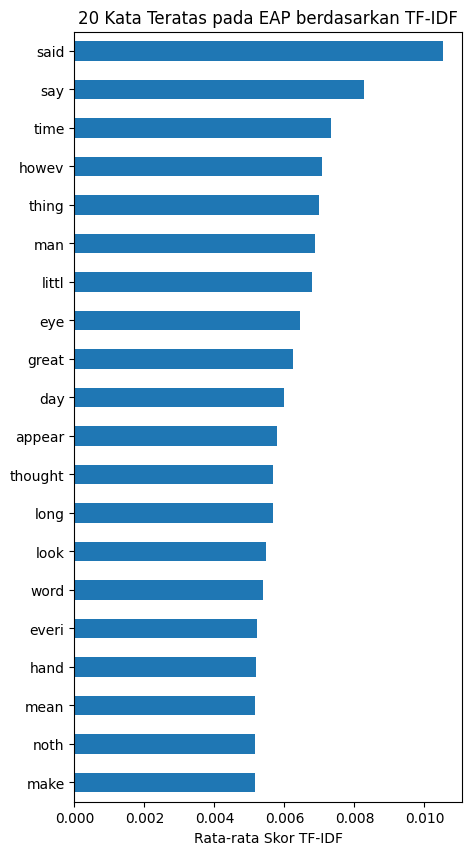

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Buat TF-IDF vectorizer
EAP_tfid_vectorizer = TfidfVectorizer(stop_words='english')
X = EAP_tfid_vectorizer.fit_transform(EAP_data['text'])

# Ambil rata-rata skor TF-IDF untuk tiap kata
average_tfidf = X.mean(axis=0).A1 
vocab = EAP_tfid_vectorizer.get_feature_names_out()

# Buat Series: kata -> skor rata-rata
EAP_vocab = pd.Series(average_tfidf, index=vocab)
EAP_vocab = EAP_vocab.sort_values(ascending=False)

# Ambil 20 kata teratas dan plot
top_vocab = EAP_vocab.head(20)
top_vocab.plot(kind='barh', figsize=(5, 10))
plt.xlabel("Rata-rata Skor TF-IDF")
plt.title("20 Kata Teratas pada EAP berdasarkan TF-IDF")
plt.gca().invert_yaxis()
plt.show()

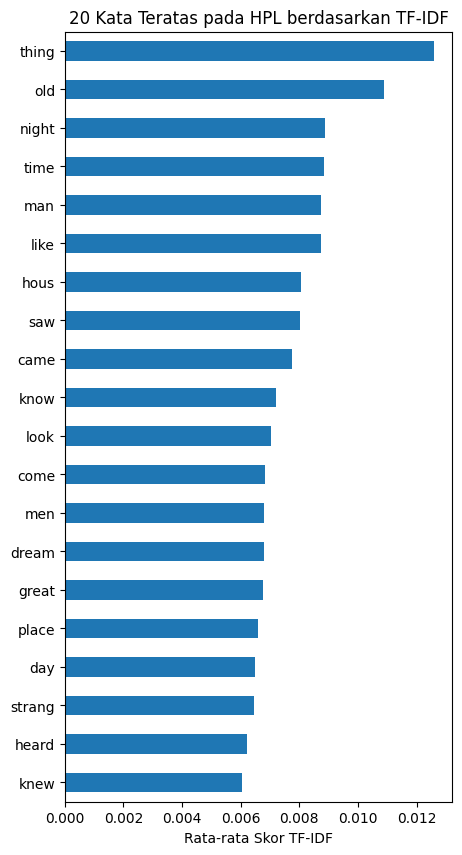

In [45]:
# Buat TF-IDF vectorizer
HPL_tfid_vectorizer = TfidfVectorizer(stop_words='english')
X = HPL_tfid_vectorizer.fit_transform(HPL_data['text'])

# Ambil rata-rata skor TF-IDF untuk tiap kata
average_tfidf = X.mean(axis=0).A1  # .A1 untuk jadi 1D array
vocab = HPL_tfid_vectorizer.get_feature_names_out()

# Buat Series: kata -> skor rata-rata
HPL_vocab = pd.Series(average_tfidf, index=vocab)
HPL_vocab = HPL_vocab.sort_values(ascending=False)

# Ambil 20 kata teratas dan plot
top_vocab = HPL_vocab.head(20)
top_vocab.plot(kind='barh', figsize=(5, 10))
plt.xlabel("Rata-rata Skor TF-IDF")
plt.title("20 Kata Teratas pada HPL berdasarkan TF-IDF")
plt.gca().invert_yaxis()
plt.show()

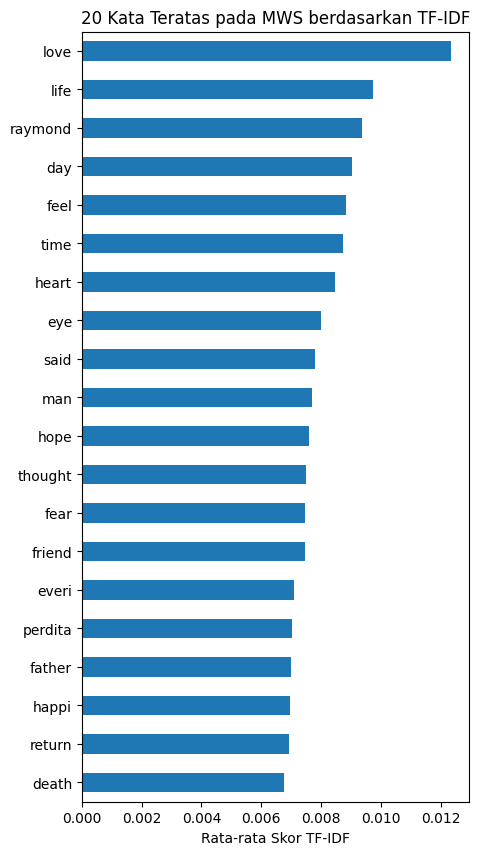

In [46]:
# Buat TF-IDF vectorizer
MWS_tfid_vectorizer = TfidfVectorizer(stop_words='english')
X = MWS_tfid_vectorizer.fit_transform(MWS_data['text'])

# Ambil rata-rata skor TF-IDF untuk tiap kata
average_tfidf = X.mean(axis=0).A1  # .A1 untuk jadi 1D array
vocab = MWS_tfid_vectorizer.get_feature_names_out()

# Buat Series: kata -> skor rata-rata
MWS_vocab = pd.Series(average_tfidf, index=vocab)
MWS_vocab = MWS_vocab.sort_values(ascending=False)

# Ambil 20 kata teratas dan plot
top_vocab = MWS_vocab.head(20)
top_vocab.plot(kind='barh', figsize=(5, 10))
plt.xlabel("Rata-rata Skor TF-IDF")
plt.title("20 Kata Teratas pada MWS berdasarkan TF-IDF")
plt.gca().invert_yaxis()
plt.show()

# **TF-IDF**

In [47]:
tfid_matrix = tfid_vectorizer.transform(train['text'])
array = tfid_matrix.todense()

In [48]:
df = pd.DataFrame(array)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.275449,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Splitting Data**

In [49]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, shuffle=True)

# **Modelling**

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

In [51]:
models = [('MultiNB', MultinomialNB(alpha=0.03)),
          ('Calibrated MultiNB', CalibratedClassifierCV(
              MultinomialNB(alpha=0.03), method='isotonic')),
          ('Calibrated BernoulliNB', CalibratedClassifierCV(
              BernoulliNB(alpha=0.03), method='isotonic')),
          ('Calibrated Huber', CalibratedClassifierCV(
              SGDClassifier(loss='modified_huber', alpha=1e-4,
                            max_iter=10000, tol=1e-4), method='sigmoid')),
          ('Logit', LogisticRegression(C=30, max_iter=1000))]

In [52]:
train = pd.read_csv("/kaggle/input/ir-2025-spooky-author-identification/train/train.csv")
vectorizer=TfidfVectorizer(token_pattern=r'\w{1,}', sublinear_tf=True, ngram_range=(1,2))
clf = VotingClassifier(models, voting='soft', weights=[3,3,3,1,1])
X_train = vectorizer.fit_transform(train.text.values)
authors = ['MWS','EAP','HPL']
y_train = train.author.apply(authors.index).values
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('MultiNB', MultinomialNB(alpha=0.03)),
                             ('Calibrated MultiNB',
                              CalibratedClassifierCV(estimator=MultinomialNB(alpha=0.03),
                                                     method='isotonic')),
                             ('Calibrated BernoulliNB',
                              CalibratedClassifierCV(estimator=BernoulliNB(alpha=0.03),
                                                     method='isotonic')),
                             ('Calibrated Huber',
                              CalibratedClassifierCV(estimator=SGDClassifier(loss='modified_huber',
                                                                             max_iter=10000,
                                                                             tol=0.0001))),
                             ('Logit',
                              LogisticRegression(C=30, max_iter=1000))],
                 voting='soft', weights=[3, 3, 3, 1, 1])

In [53]:
test = pd.read_csv("/kaggle/input/ir-2025-spooky-author-identification/test/test.csv", index_col=0)
X_test = vectorizer.transform(test.text.values)
results = clf.predict_proba(X_test)
pd.DataFrame(results, index=test.index, columns=authors).to_csv('submission.csv')

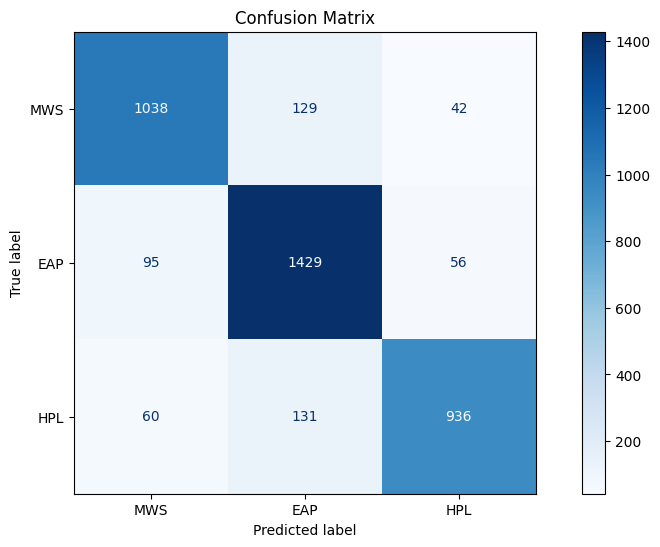

              precision    recall  f1-score   support

         MWS       0.87      0.86      0.86      1209
         EAP       0.85      0.90      0.87      1580
         HPL       0.91      0.83      0.87      1127

    accuracy                           0.87      3916
   macro avg       0.87      0.86      0.87      3916
weighted avg       0.87      0.87      0.87      3916



In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_train_split, X_val, y_train_split, y_val = train_test_split(
    train.text.values,
    train.author.apply(authors.index).values,
    test_size=0.2,
    random_state=42,
    stratify=train.author.values
)

X_train_vec = vectorizer.fit_transform(X_train_split)
X_val_vec = vectorizer.transform(X_val)

clf.fit(X_train_vec, y_train_split)

y_pred = clf.predict(X_val_vec)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=authors)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_val, y_pred, target_names=authors))